<a href="https://colab.research.google.com/github/akinoriosamura/tensorflow2.0-sample/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 59kB/s 
     |████████████████████████████████| 3.1MB 34.8MB/s 
     |████████████████████████████████| 501kB 45.3MB/s 


In [0]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

class DataLoader(object):
  def __init__(self, dataset, batch_size=100, shuffle=False, random_state=None):
    self.dataset = list(zip(dataset[0], dataset[1]))
    self.batch_size = batch_size
    self.shuffle = shuffle
    if random_state is None:
      random_state = np.random.RandomState(1234)
    self.random_state = random_state
    self._idx = 0
    self._reset()
    
  def __len__(self):
    N = len(self.dataset)
    b = batch_size
    
    return N // b + bool(N % b)
  
  def __iter__(self):
    return self
  
  def __next__(self):
    if self._idx >= len(self.dataset):
      self._reset()
      raise StopIteration()
    x, y = zip(*self.dataset[self._idx: (self._idx + self.batch_size)])
    
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)
    
    self._idx += self.batch_size
    
    return x, y 
  
  def _reset(self):
    if self.shuffle:
      self.dataset = shuffle(self.dataset, random_state=self.random_state)
      
    self._idx = 0

In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt


class VAE(Model):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def call(self, x):
    mean, var = self.encoder(x)
    z = self.reparameterize(mean, var)
    y = self.decoder(z)
    
    return y
  
  def reparameterize(self, mean, var):
    eps = tf.random.normal(mean.shape)
    z = mean + tf.math.sqrt(var) * var
    return z
  
  def lower_bound(self, x):
    mean, var = self.encoder(x)
    kl = -1/2 * tf.reduce_mean(
        tf.reduce_sum(1 + self._log(var, max=var) - mean**2 - var, axis=1)
    )
    z = self.reparameterize(mean, var)
    y = self.decoder(z)
    
    reconst = tf.reduce_mean(tf.reduce_sum(x * self._log(y) + (1 - x) * self._log(1 - y), axis=1))
    
    L = reconst - kl
    
    return L
    
    
  def _log(self, value, min=1.e-10, max=1.0):
    return tf.math.log(tf.clip_by_value(value, min, max))
  

class Encoder(Model):
  def __init__(self):
    super().__init__()
    self.l1 = Dense(200, activation='relu')
    self.l2 = Dense(200, activation='relu')
    self.l_mean = Dense(10, activation='linear')
    self.l_var = Dense(10, activation=tf.nn.softplus)

  def call(self, x):
    h = self.l1(x)
    h = self.l2(h)

    mean = self.l_mean(h)
    var = self.l_var(h)

    return mean, var


class Decoder(Model):
  def __init__(self):
    super().__init__()
    self.l1 = Dense(200, activation='relu')
    self.l2 = Dense(200, activation='relu')
    self.out = Dense(784, activation='sigmoid')

  def call(self, x):
    h = self.l1(x)
    h = self.l2(h)
    y = self.out(h)

    return y

Epoch: 1, Cost: 261.664
Epoch: 2, Cost: 247.840
Epoch: 3, Cost: 241.855
Epoch: 4, Cost: 238.308
Epoch: 5, Cost: 235.882
Epoch: 6, Cost: 234.076
Epoch: 7, Cost: 232.659
Epoch: 8, Cost: 231.510
Epoch: 9, Cost: 230.558
Epoch: 10, Cost: 229.744


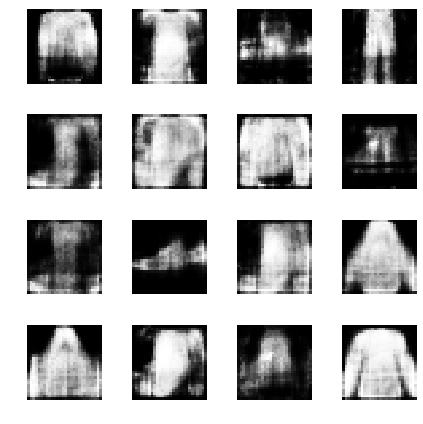

In [35]:
if __name__ == '__main__':
  np.random.seed(1234)
  tf.random.set_seed(1234)
  
  """
  1, Load data
  """
  mnist = datasets.fashion_mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = (x_train.reshape(-1, 784) / 255).astype(np.float32)
  
  train_dataloader = DataLoader((x_train, y_train), batch_size=100, shuffle=True)
  
  
  """
  2, build model
  """
  model = VAE()
  
  
  """
  3, train model
  """
  criterion = model.lower_bound
  optimizer = optimizers.Adam()
  
  @tf.function
  def compute_loss(x):
    return -1 * criterion(x)
  
  @tf.function
  def train_step(x):
    with tf.GradientTape() as tape:
      loss = compute_loss(x)
      
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    
  train_loss = metrics.Mean()
  epochs = 10
  
  for epoch in range(epochs):
    for (x, _) in train_dataloader:
      train_step(x)
      
    print('Epoch: {}, Cost: {:.3f}'.format(
        epoch+1,
        train_loss.result()
    ))
  
  """
  4, test model
  """
  def gen_noise(batch_size):
    return tf.random.normal([batch_size, 10])
  
  def generate(batch_size=16):
    z = gen_noise(batch_size)
    gen = model.decoder(z)
    gen = tf.reshape(gen, [-1, 28, 28])
    
    return gen
    
  images = generate(batch_size=16)
  images = images.numpy()
  plt.figure(figsize=(6, 6))
  for i, image in enumerate(images):
      plt.subplot(4, 4, i+1)
      plt.imshow(image, cmap='binary_r')
      plt.axis('off')
  plt.tight_layout()
  plt.show()